In [2]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras 
from keras import layers
from keras.models import Sequential 
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import inception_resnet_v2
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import glob 
import cv2
from tqdm import tqdm

In [3]:
import pathlib

dataset = pathlib.Path("lung_colon_image_set/")
images = list(dataset.glob('*/*/*.jpeg'))

print(f"Number of images : {len(images)}")

lbt = dataset.glob('lung_image_sets/lung_n/*')
laca = dataset.glob('lung_image_sets/lung_aca/*')
lscc = dataset.glob('lung_image_sets/lung_scc/*')
cacc = dataset.glob('colon_image_sets/colon_aca/*')
cbt = dataset.glob('colon_image_sets/colon_n/*')

lung_benign_tissue = list(lbt)
lung_adenocarcinoma = list(laca)
lung_squamous_cell_carcinoma = list(lscc)
colon_adenocarcinoma = list(cacc)
colon_benign_tissue = list(cbt)

x = ['Lung benign tissue','Lung adenocarcinoma','Lung squamous cell carcinoma','Colon adenocarcinoma','Colon benign tissue']
y = [len(lung_benign_tissue),len(lung_adenocarcinoma),len(lung_squamous_cell_carcinoma),len(colon_adenocarcinoma),len(colon_benign_tissue)]

Number of images : 25000


In [4]:
label_dict = {
    'lung_benign_tissue' : 0,
    'lung_adenocarcinoma' : 1,
    'lung_squamous_cell_carcinoma' : 2,
    'colon_adenocarcinoma' : 3,
    'colon_benign_tissue' : 4
}

image_dict = {
    'lung_benign_tissue' : lung_benign_tissue,
    'lung_adenocarcinoma' : lung_adenocarcinoma,
    'lung_squamous_cell_carcinoma' : lung_squamous_cell_carcinoma,
    'colon_adenocarcinoma' : colon_adenocarcinoma,
    'colon_benign_tissue' :colon_benign_tissue
}

In [5]:
x,y = [],[]

for name,images in tqdm(image_dict.items(), desc='Processing Images'):
    for i in tqdm(images, desc=f'Processing {name} Images', leave=False):
        img = cv2.imread(str(i))
        re_img = cv2.resize(img,(200,200))
        re_img=np.round((re_img.astype(np.float16)/255.0),4)
        x.append(re_img)
        y.append(label_dict[name])

x = np.array(x)
y = np.array(y)

Processing Images: 100%|██████████| 5/5 [04:00<00:00, 48.06s/it]


In [6]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=10)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=100)

In [7]:
from keras.utils import to_categorical

In [8]:
model = Sequential()
inc_res_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(200,200,3))
model.add(inc_res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(5,activation='softmax'))

for layer in inc_res_model.layers:
    layer.trainable = False

y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test,num_classes=5)
y_val_cat = to_categorical(y_val,num_classes=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [9]:
history = model.fit(x_train,y_train_cat,validation_data=(x_val,y_val_cat),epochs=5,batch_size=8)

Epoch 1/5
2000/2000 [==============================] - 975s 481ms/step - loss: 0.1936 - accuracy: 0.9306 - val_loss: 0.1071 - val_accuracy: 0.9580
Epoch 2/5
2000/2000 [==============================] - 921s 461ms/step - loss: 0.1020 - accuracy: 0.9624 - val_loss: 0.0715 - val_accuracy: 0.9715
Epoch 3/5
2000/2000 [==============================] - 925s 463ms/step - loss: 0.0815 - accuracy: 0.9697 - val_loss: 0.1130 - val_accuracy: 0.9625
Epoch 4/5
2000/2000 [==============================] - 927s 463ms/step - loss: 0.0698 - accuracy: 0.9736 - val_loss: 0.1096 - val_accuracy: 0.9610
Epoch 5/5
2000/2000 [==============================] - 928s 464ms/step - loss: 0.0603 - accuracy: 0.9780 - val_loss: 0.0971 - val_accuracy: 0.9645


In [10]:
import pandas as pd
hist = pd.DataFrame(history.history)

In [11]:
model.evaluate(x_test,y_test_cat)

63/63 [==============================] - 97s 1s/step - loss: 0.1087 - accuracy: 0.9660


[0.10866300761699677, 0.9660000205039978]

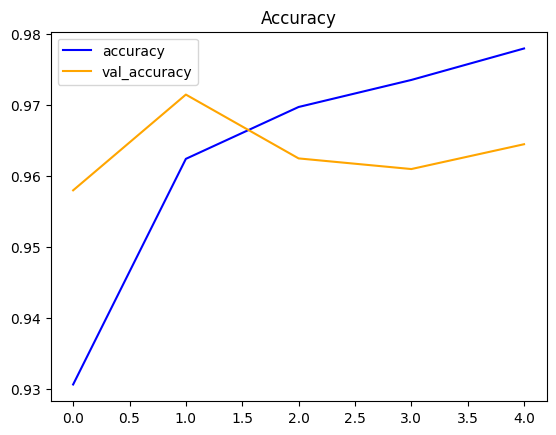

In [12]:
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

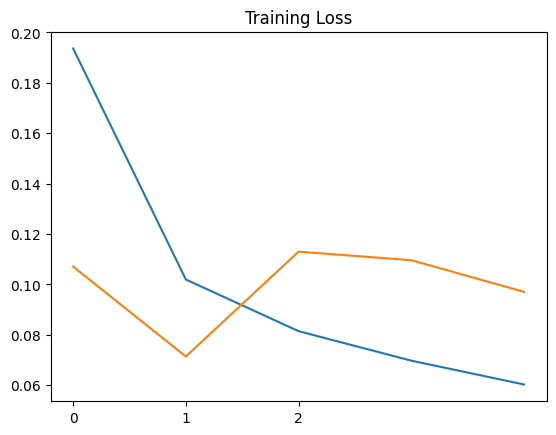

In [13]:
x=list(range(0,3))
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()

In [15]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

63/63 [==============================] - 97s 2s/step


In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       396
           1       0.98      0.87      0.92       413
           2       0.91      0.98      0.94       409
           3       0.99      0.98      0.99       378
           4       0.95      1.00      0.98       404

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

